# Bitcoin analysis and forecast based on historical trade data

### Readme

This is a Bitcoin analysis and forecast made 04 March 2017 to get me started with FB Prophet. The outcome and prediction should not be taken too seriously. Of course, if the prediction and forecast is correct, I'll take all the honor and glory and you should hire me as a great data analyst. However, the analysis shows some interesting stuff nonetheless.

The trade data is from 2011-07-17 to 2018-03-04 and was modified in the way that a mean "y" column was added.


#### Forecasts and graphs

* 1 year forecast based on all trade data
* Seasonality and holiday effects based on all trade data and holidays
* 1 year forecast based on all trade data without outlier 
* 60 day forecast based on last year trade data
* 60 day forecast based on last year trade data without anomaly 


#### Insights

* Best day to buy seems to be Wednesday
* Best day to sell seems to be Sunday
* Best month to buy seems to be April/May
* Best time to sell seems to be around new year
* End of February respective beginning of March looks like a bull trap


#### Further actions

We should check back latest 2019-03-04 to see if the forecast was correct and to make a new one ;)

### Resources
#### Prophet
https://research.fb.com/prophet-forecasting-at-scale/
#### Bitcoin trade data CSV
https://data.bitcoinity.org/markets/price/all/USD?c=e&t=l

In [1]:
import warnings
import datetime
import copy
import pandas as pd
from fbprophet import Prophet

warnings.filterwarnings('ignore')

dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S %Z') for d in dates]

df = pd.read_csv('bitcoin_trade_data_combined.CSV', parse_dates=['ds'], date_parser=dateparse, usecols=['ds', 'y'])
df.head()

,ds,y
0,2010-07-17,0.049510
1,2010-07-18,0.077975
2,2010-07-19,0.086792
3,2010-07-20,0.077999
4,2010-07-21,0.070463


We make a copy and extract the last 365 datapoints

In [2]:
dc = copy.deepcopy(df)
df_oy = dc[-365:]
df_oy.head()

,ds,y
2423,2017-03-05,1259.847148
2424,2017-03-06,1271.943358
2425,2017-03-07,1252.419780
2426,2017-03-08,1195.734754
2427,2017-03-09,1174.987293


We declare some special events that seems to bias the rate.

In [3]:
chinese_new_year = pd.DataFrame({
  'holiday': 'cny',
  'ds': pd.to_datetime(['2018-02-16', '2017-01-28', '2016-02-08',
                        '2015-02-19', '2014-01-31', '2013-02-10',
                        '2012-01-23']),
  'lower_window': -20,
  'upper_window': 20,
})
xmas = pd.DataFrame({
  'holiday': 'xmas',
  'ds': pd.to_datetime(['2011-12-24', '2012-12-24', '2013-12-24',
                        '2014-12-24', '2015-12-24', '2016-12-24',
                        '2017-12-24']),
  'lower_window': -20,
  'upper_window': 20,
})
holidays = pd.concat((chinese_new_year, xmas))

In [4]:
m = Prophet(daily_seasonality=False, holidays=holidays, holidays_prior_scale=0.05)
m.fit(df)
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3148,2019-02-28
3149,2019-03-01
3150,2019-03-02
3151,2019-03-03
3152,2019-03-04


In [5]:
forecast = m.predict(future)

In [6]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3148,2019-02-28,16391.997697,14659.531287,18041.819752
3149,2019-03-01,16403.939126,14670.017806,18058.238759
3150,2019-03-02,16428.589324,14678.483782,18162.865347
3151,2019-03-03,16434.690977,14664.491426,18065.473280
3152,2019-03-04,16441.779548,14730.230840,18128.150669


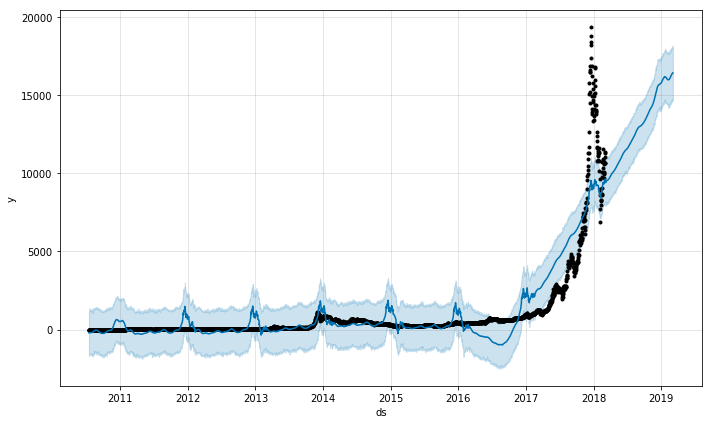

In [7]:
m.plot(forecast);

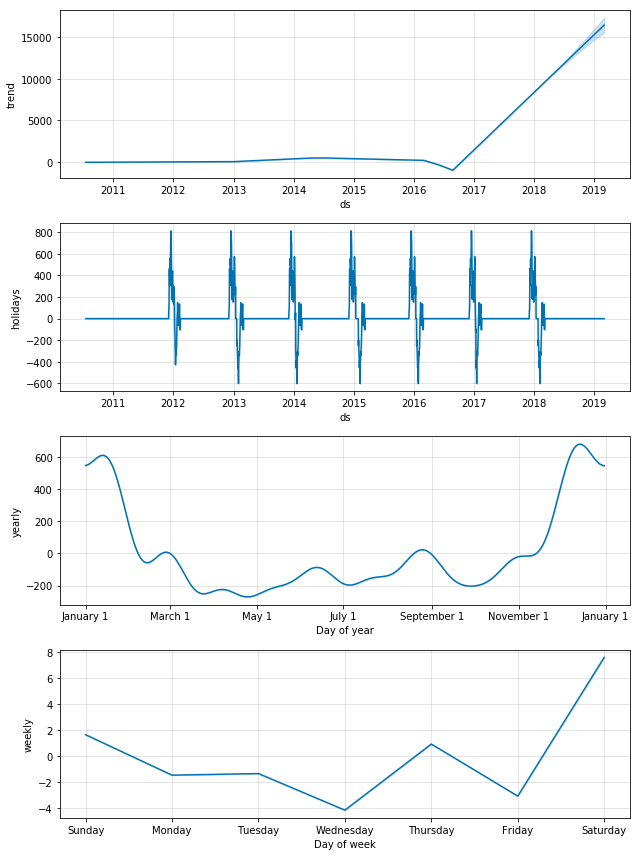

In [8]:
m.plot_components(forecast);

Now let's assume that the end of 2017 run was an outlier. We remove the outlier and see how the forecast changes

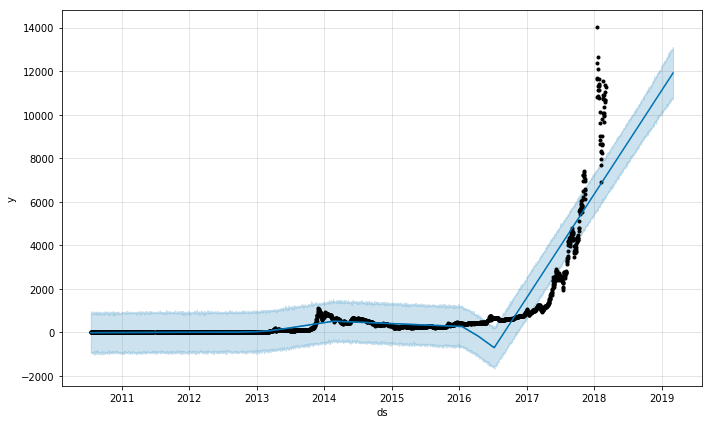

In [9]:
outlier_from = pd.Timestamp('2017-11-15')
outlier_to = pd.Timestamp('2018-01-15')
for x in range(1, len(df['ds'])):
    if (df['ds'][x] > outlier_from and df['ds'][x] < outlier_to):
        df['y'][x] = None
m_wo = Prophet(daily_seasonality=False, yearly_seasonality=False)
m_wo.fit(df)
future_wo = m_wo.make_future_dataframe(periods=365)
forecast_without_outliers = m_wo.predict(future_wo)
m_wo.plot(forecast_without_outliers);

Now we want to make a 60 day forecast based on last years data to show how important perspective is.

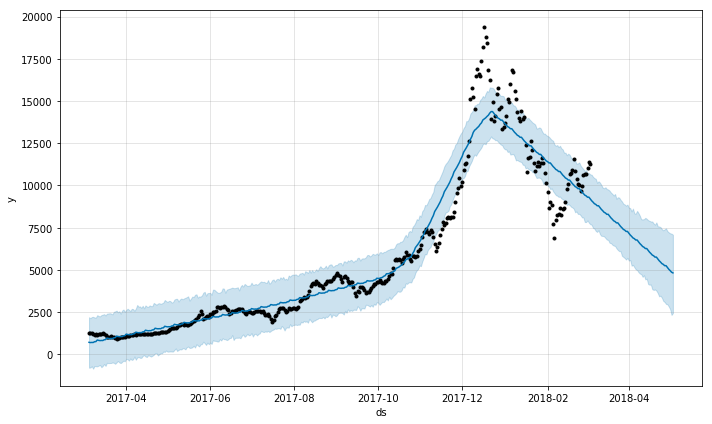

In [10]:
m_oy = Prophet(daily_seasonality=False, yearly_seasonality=False)
m_oy.fit(df_oy)
future_oy = m_oy.make_future_dataframe(periods=60)
forecast_oy = m_oy.predict(future_oy)
m_oy.plot(forecast_oy);

What happens if we forecast without the anomaly? Let's have a look.

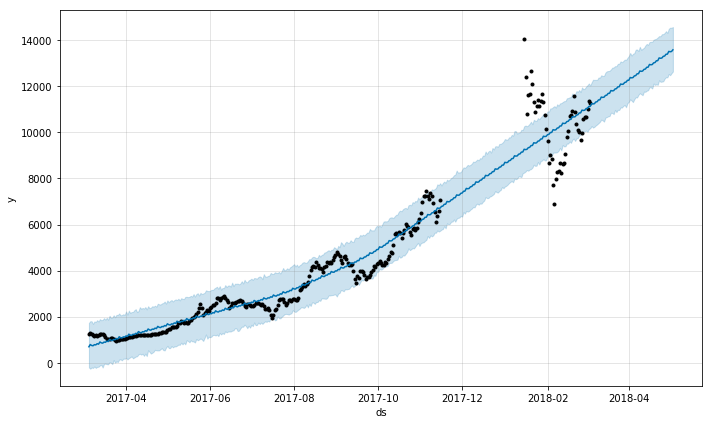

In [11]:
for i, row in df_oy.iterrows():
    if (row['ds'] > outlier_from and row['ds'] < outlier_to):
        df_oy['y'][i] = None
m_wo = Prophet(daily_seasonality=False, yearly_seasonality=False)
m_wo.fit(df_oy)
future_wo = m_wo.make_future_dataframe(periods=60)
forecast_without_outliers = m_wo.predict(future_wo)
m_wo.plot(forecast_without_outliers);

In [12]:
forecast_without_outliers[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2018-04-29,13392.592180,12384.263079,14315.618040
421,2018-04-30,13512.551645,12534.389425,14494.947900
422,2018-05-01,13497.520496,12478.173811,14543.277027
423,2018-05-02,13508.670383,12566.066432,14539.441771
424,2018-05-03,13581.431529,12638.295886,14572.261316
